# Fitting and evaluating causal models

In [119]:
import networkx as nx
import pandas as pd
import re
from dowhy import gcm
from dowhy.gcm.falsify import falsify_graph
from agentic_supply.causality_assistant.causal_graph_generation import generate_causal_graph
from agentic_supply.causality_assistant.causal_model_creation import fit_causal_model

## Data

In [120]:
path = "../data/SCMS_Delivery_History_Dataset.csv"
dataset = pd.read_csv(path)
cols_to_keep = [
    "ID",
    "Country",
    "Managed By",
    "Fulfill Via",
    "Shipment Mode",
    "Product Group",
    "Sub Classification",
    "Molecule/Test Type",
    "Brand",
    "Freight Cost (USD)",
    "Unit Price",
]
data = dataset[cols_to_keep]

In [121]:
data.dtypes

ID                      int64
Country                object
Managed By             object
Fulfill Via            object
Shipment Mode          object
Product Group          object
Sub Classification     object
Molecule/Test Type     object
Brand                  object
Freight Cost (USD)     object
Unit Price            float64
dtype: object

In [122]:
def is_not_numeric(val):
    try:
        float(val)
        return False
    except ValueError:
        return True


non_numeric_values = data["Freight Cost (USD)"].apply(is_not_numeric)
unique_non_numeric = data.loc[non_numeric_values, "Freight Cost (USD)"].unique()
print(unique_non_numeric.tolist())

['Freight Included in Commodity Cost', 'See ASN-93 (ID#:1281)', 'Invoiced Separately', 'See ASN-3562 (ID#:960)', 'See ASN-3675 (ID#:1046)', 'See ASN-242 (ID#:64)', 'See ASN-744 (ID#:1356)', 'See ASN-781 (ID#:115)', 'See ASN-2274 (ID#:610)', 'See ASN-4332 (ID#:1115)', 'See ASN-55 (ID#:16)', 'See ASN-57 (ID#:23)', 'See ASN-272 (ID#:1282)', 'See ASN-2641 (ID#:670)', 'See ASN-2921 (ID#:719)', 'See ASN-3110 (ID#:2173)', 'See ASN-3561 (ID#:2297)', 'See ASN-4419 (ID#:3851)', 'See ASN-737 (ID#:2765)', 'See ASN-1028 (ID#:2927)', 'See ASN-1231 (ID#:2947)', 'See ASN-2023 (ID#:3094)', 'See ASN-2336 (ID#:530)', 'See ASN-2448 (ID#:1939)', 'See ASN-61 (ID#:5260)', 'See ASN-123 (ID#:2685)', 'See ASN-276 (ID#:2686)', 'See ASN-1230 (ID#:1530)', 'See ASN-2717 (ID#:791)', 'See ASN-3313 (ID#:3456)', 'See ASN-3635 (ID#:3745)', 'See ASN-3760 (ID#:5049)', 'See ASN-4420 (ID#:1183)', 'See ASN-4488 (ID#:1213)', 'See ASN-127 (ID#:3955)', 'See ASN-273 (ID#:1283)', 'See ASN-990 (ID#:1502)', 'See ASN-2335 (ID#:5796)

In [123]:
for index, row in data.iterrows():
    match = re.search(r"ID#:(\d+)", row["Freight Cost (USD)"])
    if match:
        id_match = int(match.group(1))
        row_condition = data["ID"] == id_match
        data.at[index, "Freight Cost (USD)"] = data.loc[row_condition, "Freight Cost (USD)"].values[0]

In [124]:
data.isna().sum()

ID                      0
Country                 0
Managed By              0
Fulfill Via             0
Shipment Mode         360
Product Group           0
Sub Classification      0
Molecule/Test Type      0
Brand                   0
Freight Cost (USD)      0
Unit Price              0
dtype: int64

In [125]:
data[["Freight Cost (USD)"]]

,Freight Cost (USD)
0,780.34
1,4521.5
2,1653.78
3,16007.06
4,45450.08
...,...
10319,46111.55
10320,14734.92
10321,Freight Included in Commodity Cost
10322,Freight Included in Commodity Cost


In [126]:
data.loc[:, "Freight Cost (USD)"] = data["Freight Cost (USD)"].apply(pd.to_numeric, errors="coerce")
data.loc[:, "Freight Cost (USD)"] = data[["Freight Cost (USD)"]].fillna(value=0.0)

C:\Users\2379549\AppData\Local\Temp\ipykernel_30600\991721864.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[:, "Freight Cost (USD)"] = data[["Freight Cost (USD)"]].fillna(value=0.0)


In [127]:
data.loc[:, "Shipment Mode"] = data[["Shipment Mode"]].fillna(value="None")

## Graph

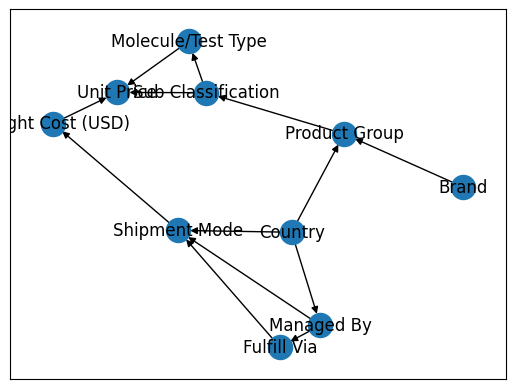

In [117]:
graph = generate_causal_graph()
nx.draw_networkx(graph)

In [ ]:
result = falsify_graph(graph, data, show_progress_bar=True)
print(result)

## Model

In [ ]:
model = fit_causal_model(data=data, graph=graph)

c:\ProjetsCode\AgenticSupply\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\ProjetsCode\AgenticSupply\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
Fitting causal mechanism of node Unit Price: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]       


Test permutations of given graph: 100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


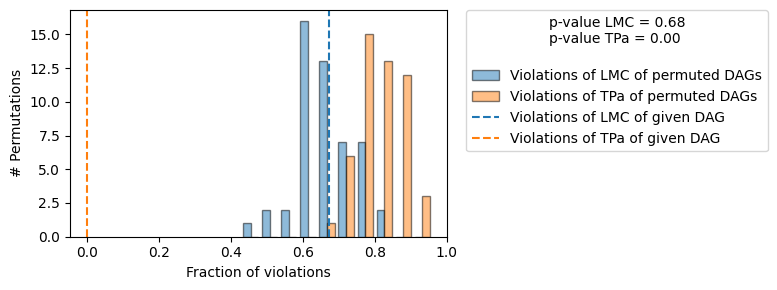

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [115]:
summary_evaluation = gcm.evaluate_causal_model(model, data, compare_mechanism_baselines=True)
print(summary_evaluation)